This is a project for detecting the action of falling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import keras
import numpy as np
import json
import os
import csv
import pandas as pd
import subprocess
import xgboost as xgb

# New Section

**Now we are cleaning all the data**

In [ ]:
# now we read all the data
dataPath = "/content/drive/MyDrive/Colab Notebooks/data"

In [ ]:
def readDataFrame(path, totalData, totalLabel):  
  total_df = pd.read_csv(path, header=None)
  label = total_df.iloc[:, 63]
  totalLabel += label.to_list()
  # now drop the label column
  total_df = total_df.drop(total_df.columns[63], axis = 1)
  for index, row in total_df.iterrows():
    totalData.append(row.to_list())
  return totalData, totalLabel

In [ ]:
# now we read in all the data
Data = []
Label = []
for itemPath in os.listdir(dataPath):
  item = os.path.join(dataPath, itemPath)
  Data, Label = readDataFrame(item, Data, Label)


In [ ]:
print("data length is " + str(len(Data)))
print("label length is " + str(len(Label)))

data length is 56893
label length is 56893


In [ ]:
print("non falling label: " + str(Label.count(0)))
print("falling label: " + str(Label.count(1)))

non falling label: 53003
falling label: 3890


In [ ]:
# now we need to up-sampling to balance the data
totalData = []
for i in range(len(Data)):
  totalData.append(Data[i])
  totalData[i].append(Label[i])    
df = pd.DataFrame.from_records(totalData)
df = df.rename(columns={df.columns[63]: "labels"})
fallDf = df[df['labels'] == 1]
nonFallDf = df[df['labels'] == 0]
from sklearn.utils import resample
sampled_fallDf = resample(fallDf, replace = True, n_samples=len(nonFallDf))
newData = pd.concat([nonFallDf, sampled_fallDf])
newData.labels.value_counts()

1    53003
0    53003
Name: labels, dtype: int64

In [ ]:

# next we shuffle the data and split them
totalData = newData.values
np.random.shuffle(totalData)
test_data = totalData[: len(totalData) // 9]
train_data = totalData[len(totalData) // 9:]
print("train: " + str(len(train_data)))
print("test: " + str(len(test_data)))

train: 94228
test: 11778


In [ ]:
# prepare all the training data and label
from keras.layers import LSTM
from keras import callbacks
from keras import layers
from keras.models import Sequential


train_x = []
train_y = []
for data in train_data:
  train_x.append(data[:63])
  train_y.append(int(data[63]))
train_x = np.array(train_x)
train_x = train_x.reshape((len(train_x), 1, len(train_x[0])))
train_y = np.array(train_y)

In [ ]:
print(train_x.shape)
print(train_y.shape)

(94228, 1, 63)
(94228,)


In [ ]:

# function for plotting the results
import matplotlib.pyplot as plt
def plotting_training(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.show()
  # Plot training & validation loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label="Train loss")
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
# this is the dynamic learning rate function
def learningRate(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

In [ ]:

# we start with GRU
model = Sequential()
model.add(layers.Conv1D(32, 1, activation='relu', input_shape=(1, 63)))
model.add(layers.MaxPool1D(1))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.GRU(32, dropout= 0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='acc', patience = 3), callbacks.LearningRateScheduler(learningRate)] )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 32)             2048      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 32)             1056      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
4712/4712 [==============================] - 58s 8ms/step - loss: 0.5720 - acc: 0.6857 - val_loss: 0.4857 - v

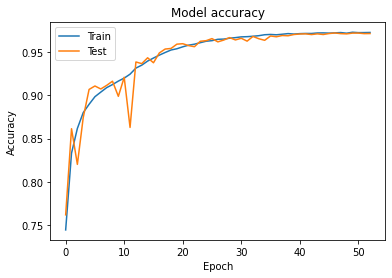

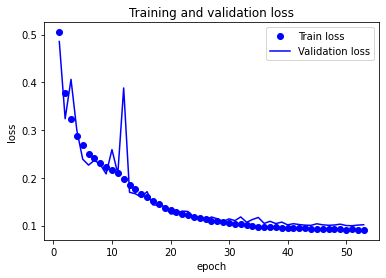

737/737 [==============================] - 2s 2ms/step - loss: 0.1018 - acc: 0.9715
test loss, test acc:  [0.10177555680274963, 0.9714722633361816]


In [ ]:
plotting_training(history)
test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 1, len(test_x[0])))
test_y = np.array(test_y)
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelGRU.h5")

In [ ]:

from keras.models import Sequential
from keras.layers import Embedding, Dense
model = Sequential()
model.add(LSTM(32, input_shape=(1, 63), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(learningRate)] )

Epoch 1/60
4712/4712 [==============================] - 27s 5ms/step - loss: 0.5813 - acc: 0.6790 - val_loss: 0.4421 - val_acc: 0.7958
Epoch 2/60
4712/4712 [==============================] - 23s 5ms/step - loss: 0.4346 - acc: 0.7953 - val_loss: 0.4993 - val_acc: 0.7675
Epoch 3/60
4712/4712 [==============================] - 24s 5ms/step - loss: 0.3815 - acc: 0.8278 - val_loss: 0.4216 - val_acc: 0.8098
Epoch 4/60
4712/4712 [==============================] - 24s 5ms/step - loss: 0.3426 - acc: 0.8500 - val_loss: 0.4448 - val_acc: 0.7890
Epoch 5/60
4712/4712 [==============================] - 24s 5ms/step - loss: 0.3115 - acc: 0.8676 - val_loss: 0.2826 - val_acc: 0.8845
Epoch 6/60
4712/4712 [==============================] - 24s 5ms/step - loss: 0.2865 - acc: 0.8809 - val_loss: 0.4404 - val_acc: 0.8052
Epoch 7/60
4712/4712 [==============================] - 24s 5ms/step - loss: 0.2683 - acc: 0.8886 - val_loss: 0.2412 - val_acc: 0.9046
Epoch 8/60
4712/4712 [==============================] -

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/projectModelLSTM.h5')

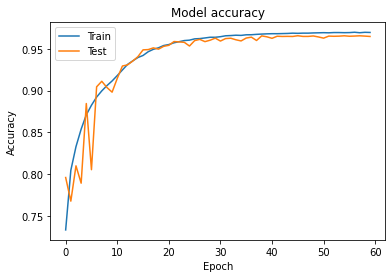

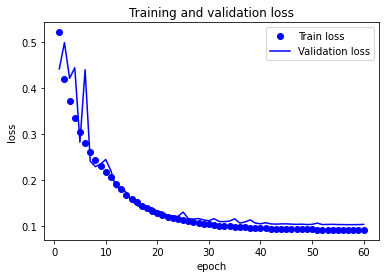

In [ ]:
plotting_training(history)

In [ ]:
test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 1, len(test_x[0])))
test_y = np.array(test_y)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)


737/737 [==============================] - 2s 2ms/step - loss: 0.1067 - acc: 0.9647
test loss, test acc:  [0.10674462467432022, 0.9646798968315125]


Epoch 1/60
4712/4712 [==============================] - 43s 8ms/step - loss: 0.5734 - acc: 0.6843 - val_loss: 0.4296 - val_acc: 0.8011
Epoch 2/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.4239 - acc: 0.8037 - val_loss: 0.4276 - val_acc: 0.7909
Epoch 3/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.3618 - acc: 0.8394 - val_loss: 0.3508 - val_acc: 0.8364
Epoch 4/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.3172 - acc: 0.8634 - val_loss: 0.3215 - val_acc: 0.8630
Epoch 5/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.2744 - acc: 0.8867 - val_loss: 0.2370 - val_acc: 0.9079
Epoch 6/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.2506 - acc: 0.8963 - val_loss: 0.3651 - val_acc: 0.8361
Epoch 7/60
4712/4712 [==============================] - 37s 8ms/step - loss: 0.2265 - acc: 0.9075 - val_loss: 0.2268 - val_acc: 0.9056
Epoch 8/60
4712/4712 [==============================] -

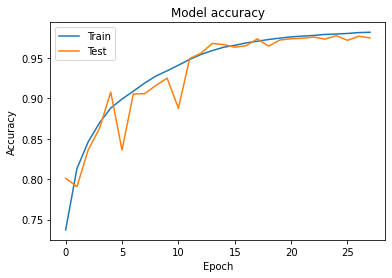

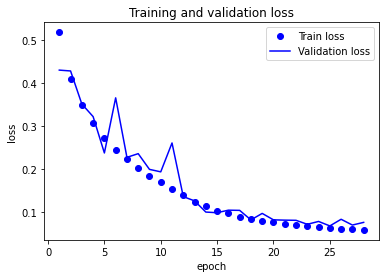

In [ ]:

# now we use the bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, 63)))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 3), callbacks.LearningRateScheduler(learningRate)] )

plotting_training(history)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelBILSTM.h5")

737/737 [==============================] - 3s 3ms/step - loss: 0.0745 - acc: 0.9761
test loss, test acc:  [0.07452072948217392, 0.9761419892311096]


In [ ]:
# next we try the CNN
#create model
# we first reshape our data
train_x = []
train_y = []
for data in train_data:
  train_x.append(data[:63])
  train_y.append(int(data[63]))
train_x = np.array(train_x)
train_x = train_x.reshape((len(train_x), 3, int(len(train_x[0])/3), 1))
train_y = np.array(train_y)
print("shape of input data: ", train_x.shape)

test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 3, int(len(test_x[0])/3), 1))
test_y = np.array(test_y)

shape of input data:  (94228, 3, 21, 1)


Epoch 1/60
4712/4712 [==============================] - 42s 5ms/step - loss: 0.4565 - acc: 0.7900 - val_loss: 0.1652 - val_acc: 0.9338
Epoch 2/60
4712/4712 [==============================] - 26s 6ms/step - loss: 0.1476 - acc: 0.9459 - val_loss: 0.0896 - val_acc: 0.9702
Epoch 3/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.0951 - acc: 0.9667 - val_loss: 0.0757 - val_acc: 0.9710
Epoch 4/60
4712/4712 [==============================] - 26s 5ms/step - loss: 0.0724 - acc: 0.9765 - val_loss: 0.0452 - val_acc: 0.9862
Epoch 5/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.0557 - acc: 0.9822 - val_loss: 0.0382 - val_acc: 0.9886
Epoch 6/60
4712/4712 [==============================] - 26s 5ms/step - loss: 0.0453 - acc: 0.9858 - val_loss: 0.0391 - val_acc: 0.9903
Epoch 7/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.0389 - acc: 0.9874 - val_loss: 0.0437 - val_acc: 0.9871
Epoch 8/60
4712/4712 [==============================] -

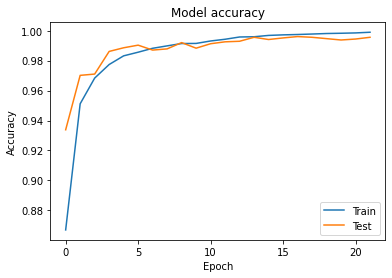

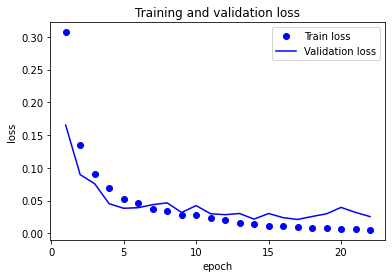

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  input_shape=(3,21,1), 
                  padding='same'))
model.add(layers.BatchNormalization(1))
model.add(layers.Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  padding='same'))
model.add(layers.BatchNormalization(1))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(Dense(512, activation = 'relu')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(learningRate)] )
plotting_training(history)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelCNN.h5")

737/737 [==============================] - 2s 3ms/step - loss: 0.0219 - acc: 0.9968
test loss, test acc:  [0.02194555662572384, 0.9967736601829529]


In [ ]:
# let's try XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = newData.iloc[:, :-1]
Y = newData.iloc[:, -1]
test_size = 0.3333

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=7)


In [ ]:
model = XGBClassifier(n_estimators=500, max_depth=5, learning_rate=0.1, verbosity=1, reg_lambda=5, random_state=7)
model.fit(x_train, y_train,  verbose=True)
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.56%


In [ ]:
model.save_model("/content/drive/MyDrive/Colab Notebooks/projectXGB.h5")

ValueError: ignored

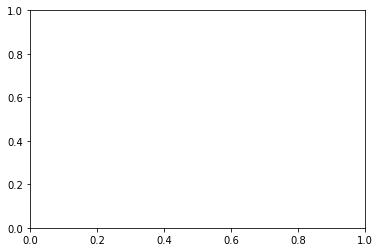

In [ ]:
from xgboost import plot_tree
plot_tree(model, num_trees=10)